In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os

import time
import json
from PIL import Image
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu


In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510573713/13510573713 [==============================] - 272s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)


In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:]
print(len(train_image_paths))

82783


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
len(train_captions)


414113

In [ ]:
len(img_name_vector)

414113

<start> A traffic light hanging from the side of a pole. <end>


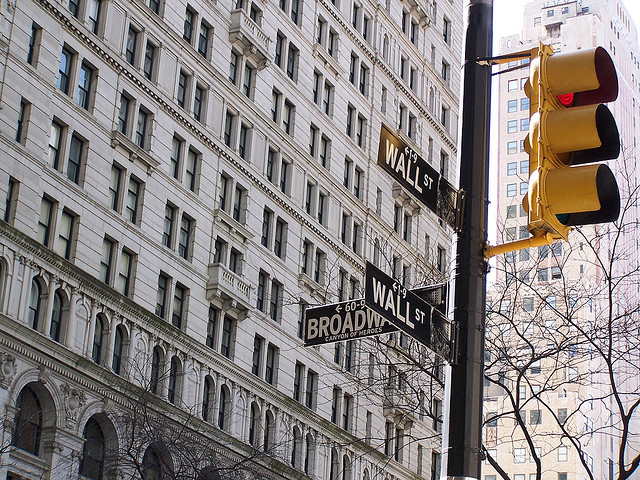

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 5174/5174 [16:21<00:00,  5.27it/s]


In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 20000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

In [ ]:
"""
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])
"""

### Create a tf.data dataset for training

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE


In [ ]:
"""
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

embedding_dim = 256
units = 512
vocab_size = top_k + 1
"""

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def __call__(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def __call__(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def __call__(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size,
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def __call__(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def __call__(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def __call__(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)  # Cast step to float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        d_model_float = tf.cast(self.d_model, dtype=tf.float32)  # Cast d_model to float32

        return tf.math.rsqrt(d_model_float) * tf.math.minimum(arg1, arg2)


In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
!ls

annotations  sample_data  train2014


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/model_chkp/MSCOCO/"
ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  print(ckpt_manager.latest_checkpoint)
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(start_epoch)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  dec_mask = create_masks_decoder(tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp,
                                 True,
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
total_epoch = 2

for epoch in range(start_epoch,total_epoch):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
  if epoch % 5 == 0:
      ckpt_manager.save()


  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.8771 Accuracy 0.0000
Epoch 1 Batch 50 Loss 9.5430 Accuracy 0.0211
Epoch 1 Batch 100 Loss 9.1806 Accuracy 0.0268
Epoch 1 Batch 150 Loss 8.8422 Accuracy 0.0293
Epoch 1 Batch 200 Loss 8.4506 Accuracy 0.0338
Epoch 1 Batch 250 Loss 8.0270 Accuracy 0.0372
Epoch 1 Batch 300 Loss 7.6284 Accuracy 0.0394
Epoch 1 Batch 350 Loss 7.2858 Accuracy 0.0415
Epoch 1 Batch 400 Loss 6.9958 Accuracy 0.0440
Epoch 1 Batch 450 Loss 6.7512 Accuracy 0.0462
Epoch 1 Batch 500 Loss 6.5349 Accuracy 0.0483
Epoch 1 Batch 550 Loss 6.3415 Accuracy 0.0504
Epoch 1 Batch 600 Loss 6.1647 Accuracy 0.0522
Epoch 1 Batch 650 Loss 6.0102 Accuracy 0.0540
Epoch 1 Batch 700 Loss 5.8677 Accuracy 0.0556
Epoch 1 Batch 750 Loss 5.7355 Accuracy 0.0572
Epoch 1 Batch 800 Loss 5.6181 Accuracy 0.0586
Epoch 1 Batch 850 Loss 5.5065 Accuracy 0.0600
Epoch 1 Batch 900 Loss 5.4063 Accuracy 0.0612
Epoch 1 Batch 950 Loss 5.3123 Accuracy 0.0624
Epoch 1 Batch 1000 Loss 5.2256 Accuracy 0.0635
Epoch 1 Batch 1050 Loss 5.1449 Accur

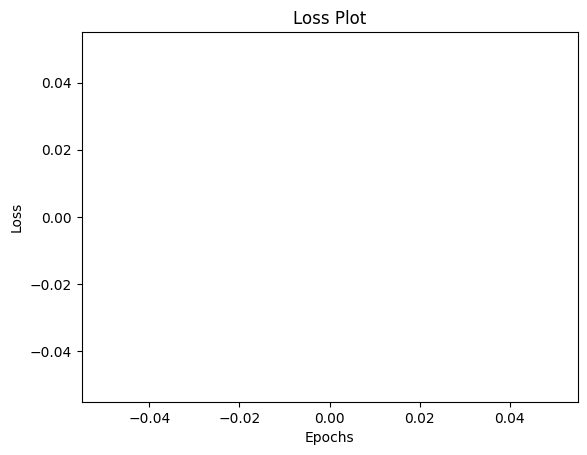

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
transformer.save_weights('caption_transformer_MSCOCO.h5')

In [ ]:
transformer.save_weights('/content/gdrive/MyDrive/model_weights/MSCOCO/')

In [ ]:
 tf.saved_model.save(transformer,"/content/gdrive/MyDrive/saved_model/MSCOCO/")

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']

  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(32):
      dec_mask = create_masks_decoder(output)

      # predictions.shape == (batch_size, seq_len, vocab_size)

      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

-------------------START----------------------


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1 score: 70.0
BLEU-2 score: 48.30458915396479
BLEU-3 score: 3.27036604491396e-91
BLEU-4 score: 1.036731780994569e-152
Ground Truth: a cat sitting on the roof of a car
Predicted Caption: a cat is sitting on a car in the street


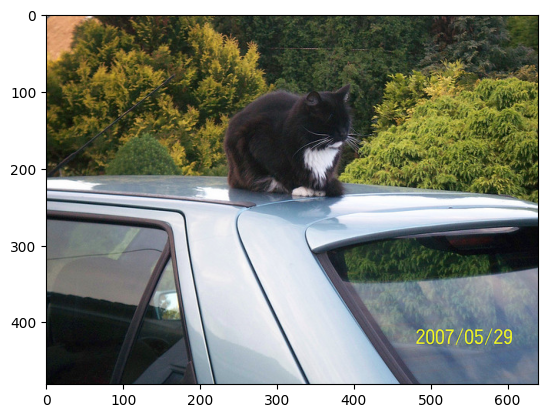

-------------------START----------------------


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1 score: 19.470019576785123
BLEU-2 score: 5.808561601872144e-153
BLEU-3 score: 1.3158762272049197e-183
BLEU-4 score: 1.0032743411283238e-229
Ground Truth: a large pizza that just came out of the oven
Predicted Caption: a pizza with cheese and cheese on top


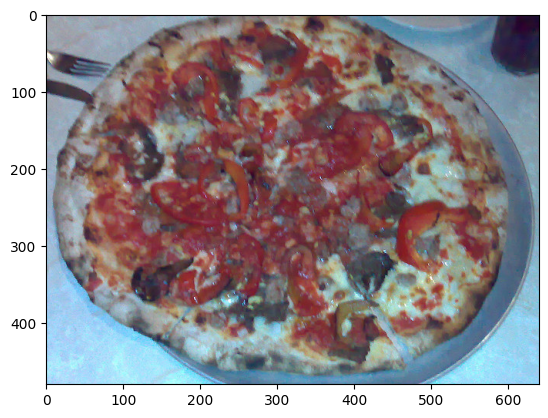

-------------------START----------------------
BLEU-1 score: 30.326532985631673
BLEU-2 score: 6.397495320955232e-153
BLEU-3 score: 1.261683487508958e-183
BLEU-4 score: 9.291879812217675e-230
Ground Truth: a city street with lots of blurry traffic on top of it
Predicted Caption: a large building with a clock on it


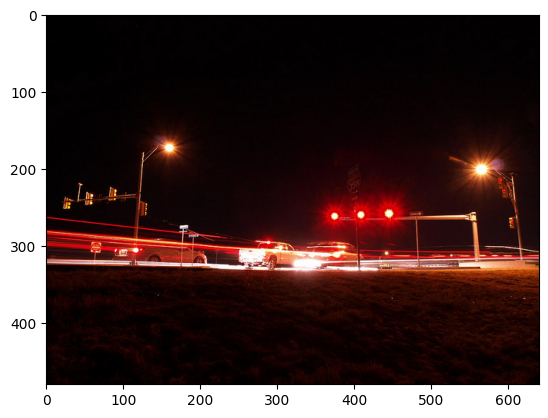

-------------------START----------------------
BLEU-1 score: 44.44444444444444
BLEU-2 score: 23.570226039551585
BLEU-3 score: 2.1262855015914923e-91
BLEU-4 score: 7.241926111174567e-153
Ground Truth: a folded umbrella sitting in a plastic lined bucket
Predicted Caption: a person holding a colorful umbrella in a field


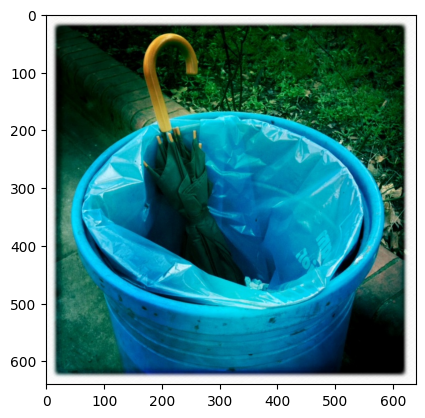

-------------------START----------------------
BLEU-1 score: 45.241870901797974
BLEU-2 score: 30.161247267865317
BLEU-3 score: 25.08249895821454
BLEU-4 score: 3.793792167347796e-76
Ground Truth: a laptop computer is on the floor with a note book
Predicted Caption: a laptop computer sitting on top of a wooden desk


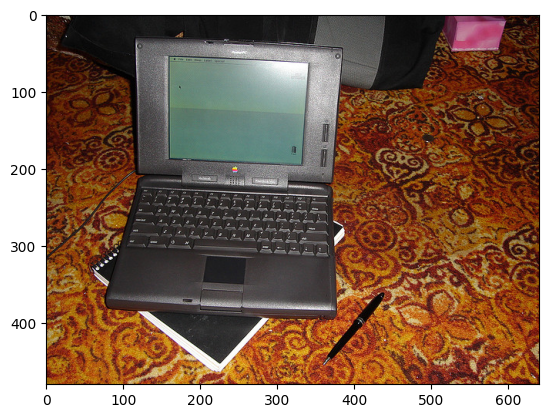

-------------------START----------------------
BLEU-1 score: 12.262648039048077
BLEU-2 score: 3.168232950523297e-153
BLEU-3 score: 6.776037495668201e-184
BLEU-4 score: 5.092529201164552e-230
Ground Truth: in this kitchen the stove is in the middle of the room with an exhaust hood above it
Predicted Caption: a kitchen with a stove top and a stove


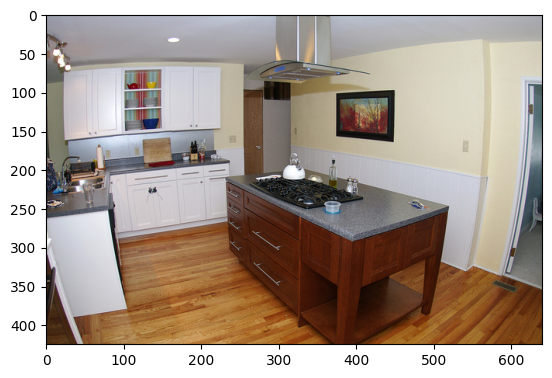

-------------------START----------------------
BLEU-1 score: 20.0
BLEU-2 score: 6.6709427497276e-153
BLEU-3 score: 1.5802130991274055e-183
BLEU-4 score: 1.2183324802375697e-229
Ground Truth: a couple of men riding up a ski covered slope
Predicted Caption: a group of people standing on skis in the snow


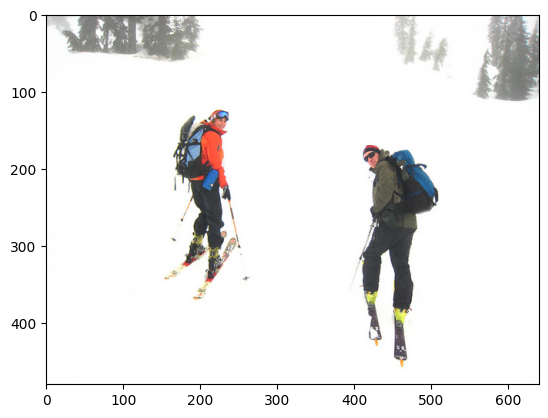

-------------------START----------------------
BLEU-1 score: 60.0
BLEU-2 score: 25.819888974716104
BLEU-3 score: 2.2458252053838132e-91
BLEU-4 score: 7.57965434483665e-153
Ground Truth: a small sink by the window in a bathroom
Predicted Caption: a bathroom with a toilet and sink in the corner


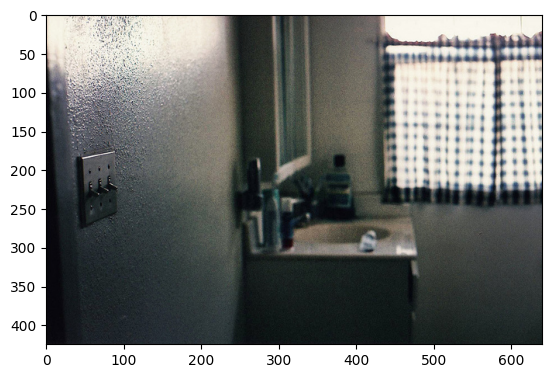

-------------------START----------------------
BLEU-1 score: 37.8978599125082
BLEU-2 score: 17.775671939720908
BLEU-3 score: 1.6692212009878278e-91
BLEU-4 score: 5.742538458835147e-153
Ground Truth: a child looks back at the camera while in front of a laptop
Predicted Caption: a young child is sitting at a table with a laptop


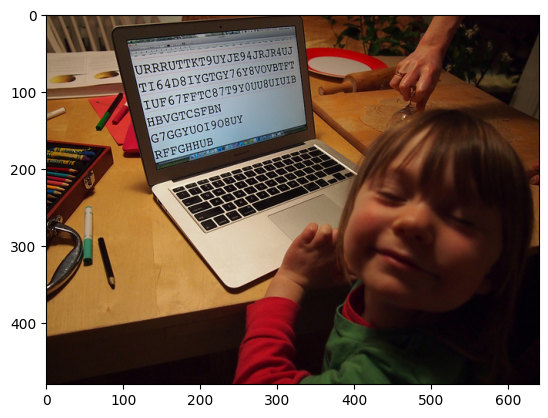

-------------------START----------------------
BLEU-1 score: 44.44444444444444
BLEU-2 score: 23.570226039551585
BLEU-3 score: 2.1262855015914923e-91
BLEU-4 score: 7.241926111174567e-153
Ground Truth: a male professional tennis player serving the ball
Predicted Caption: a tennis player is swinging at a tennis ball


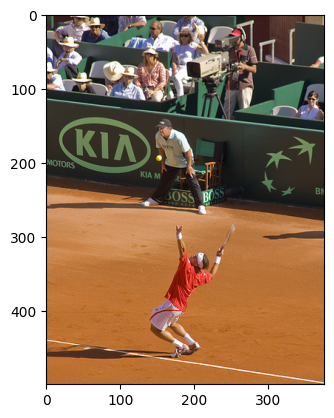

-----------------------END-----------------------
-------------------START----------------------
BLEU-1 score: 22.062422564614888
BLEU-2 score: 6.581962593704787e-153
BLEU-3 score: 1.4910831112846667e-183
BLEU-4 score: 1.1368587676511997e-229
Ground Truth: a woman tennis playing preparing to serve the ball
Predicted Caption: a tennis player is holding a tennis racket


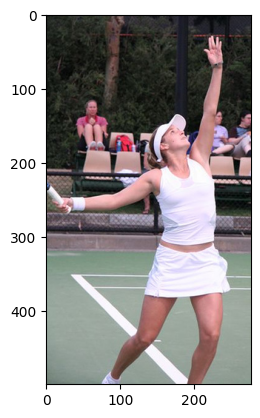

-------------------START----------------------
BLEU-1 score: 32.52557277924794
BLEU-2 score: 17.14248203066608
BLEU-3 score: 1.2254667653243162e-91
BLEU-4 score: 3.938007603125569e-153
Ground Truth: the sink of a hotel bathroom with toiletries on one side and a coffee maker on the other side
Predicted Caption: a bathroom with a sink and mirror on the wall


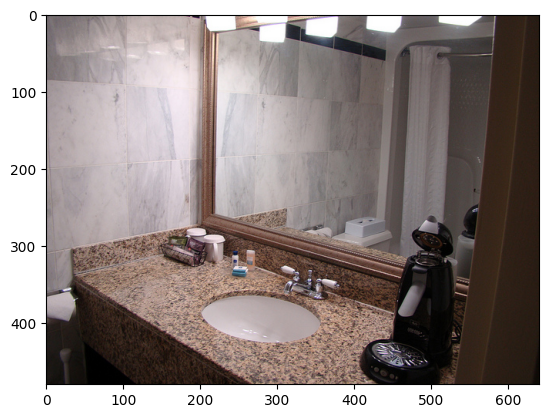

-------------------START----------------------
BLEU-1 score: 20.10960138106918
BLEU-2 score: 5.476650797505702e-153
BLEU-3 score: 1.1962590669600284e-183
BLEU-4 score: 9.03796893961078e-230
Ground Truth: a statue of a chef stands in front of some chefs in a kitchen
Predicted Caption: a man standing next to a wall with a clock


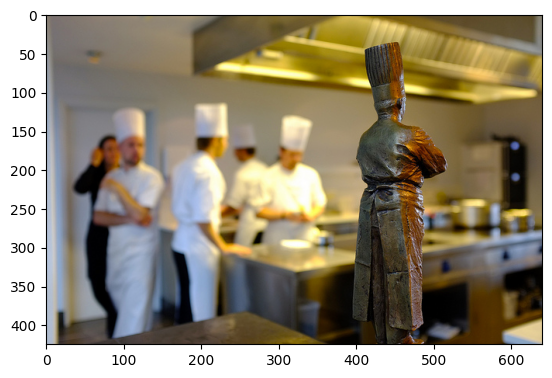

-------------------START----------------------
BLEU-1 score: 45.45454545454545
BLEU-2 score: 21.320071635561046
BLEU-3 score: 2.0020574018996266e-91
BLEU-4 score: 6.887578243315168e-153
Ground Truth: a yellow fire hydrant in a weedy poorly maintained area
Predicted Caption: a red fire hydrant sitting in the middle of a road


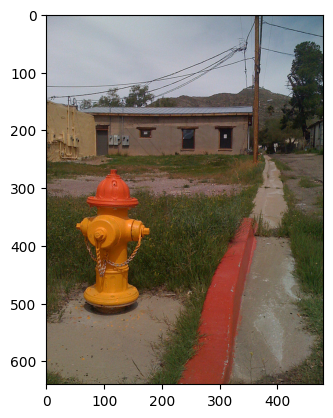

-------------------START----------------------
BLEU-1 score: 10.000000000000002
BLEU-2 score: 4.717068855239749e-153
BLEU-3 score: 1.2835318765197404e-183
BLEU-4 score: 1.0244914152188952e-229
Ground Truth: several planes are flying high in the air together
Predicted Caption: a large white airplane flying through a clear blue sky


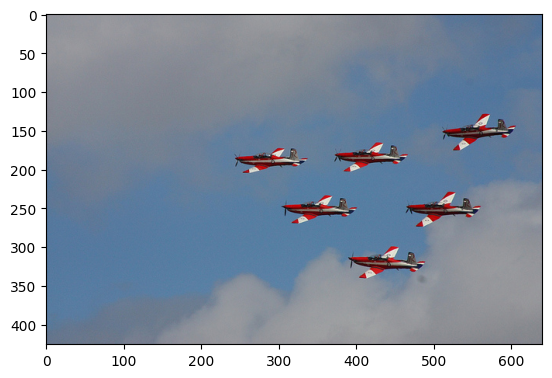

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
for r in range (15):
  print('-------------------START----------------------')
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

  caption,result,attention_weights = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  #remove <end> from result
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption
  score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  print(f"BLEU-1 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  print(f"BLEU-2 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  print(f"BLEU-3 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  print(f"BLEU-4 score: {score*100}")

  print ('Ground Truth:', real_caption)
  print ('Predicted Caption:', ' '.join(caption))
  temp_image = np.array(Image.open(image))
  plt.imshow(temp_image)
  plt.show()
  if (r == 9):
    print('-----------------------END-----------------------')


Predicted Caption: a man is holding a bike in the snow


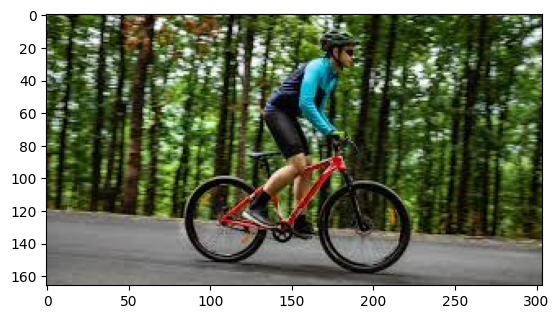

In [ ]:
sample_image = '/content/gdrive/MyDrive/cycle.jpeg'
caption,result,attention_weights = evaluate(sample_image)

for i in caption:
    if i=="<unk>":
        caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(sample_image))
plt.imshow(temp_image)
plt.show()



Predicted Caption: a woman holding a teddy bear while holding a teddy bear


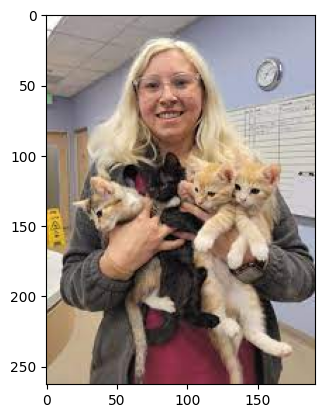

In [ ]:
sample_image = '/content/gdrive/MyDrive/kitten.jpeg'
caption,result,attention_weights = evaluate(sample_image)

for i in caption:
    if i=="<unk>":
        caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(sample_image))
plt.imshow(temp_image)
plt.show()

Predicted Caption: a dog is laying on a white frisbee


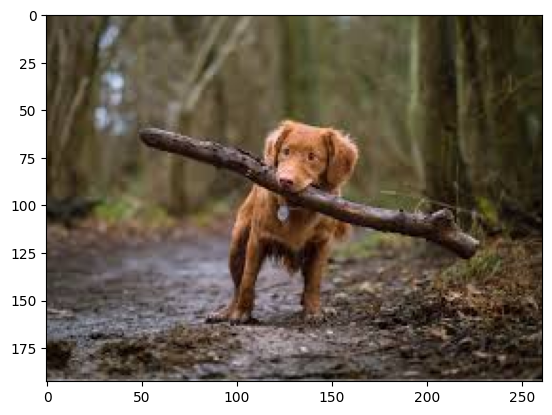

In [ ]:
sample_image = '/content/gdrive/MyDrive/dog.jpeg'
caption,result,attention_weights = evaluate(sample_image)

for i in caption:
    if i=="<unk>":
        caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(sample_image))
plt.imshow(temp_image)
plt.show()

Predicted Caption: a man doing a trick on a skateboard


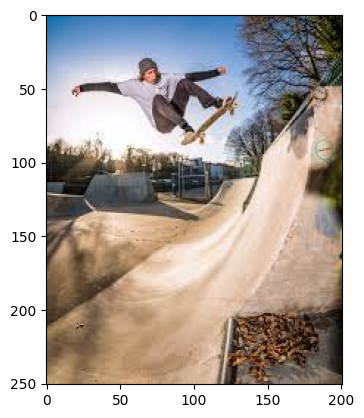

In [ ]:
sample_image = '/content/gdrive/MyDrive/skate.jpeg'
caption,result,attention_weights = evaluate(sample_image)

for i in caption:
    if i=="<unk>":
        caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(sample_image))
plt.imshow(temp_image)
plt.show()

Predicted Caption: a group of people playing soccer on a field


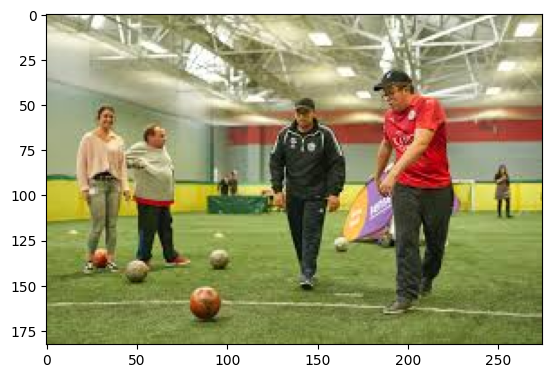

In [ ]:
sample_image = '/content/gdrive/MyDrive/people.jpeg'
caption,result,attention_weights = evaluate(sample_image)

for i in caption:
    if i=="<unk>":
        caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(sample_image))
plt.imshow(temp_image)
plt.show()